IMPORTING NECESSARY LIBRARIES.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from scipy.stats import gaussian_kde
import pickle

READING CSV FILE. CONVERTING IT TO DATAFRAME AND PERFORMING EXPLORATORY ANALYSIS ON THE DATASET.

In [2]:
house_price_dataset = pd.read_csv('Mumbai House Prices.csv')

In [3]:
house_price_df = pd.DataFrame(house_price_dataset)

In [4]:
house_price_df.shape

(76038, 9)

In [5]:
house_price_df.head()

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New


In [6]:
house_price_df.isnull().sum()

bhk           0
type          0
locality      0
area          0
price         0
price_unit    0
region        0
status        0
age           0
dtype: int64

In [7]:
house_price_df.describe()

,bhk,area,price
count,76038.000000,76038.000000,76038.00000
mean,2.015111,1024.536850,29.38227
std,0.922754,670.276165,32.90345
min,1.000000,127.000000,1.00000
25%,1.000000,640.000000,1.75000
50%,2.000000,872.000000,5.50000
75%,3.000000,1179.000000,59.00000
max,10.000000,16000.000000,99.99000


CONVERTING CRORES TO LAKHS AND DROPPING THE price_unit COLUMN.

In [8]:
house_price_df['price_in_Lakhs'] = house_price_df.apply(
    lambda row: row['price'] * 100 if row['price_unit'] == 'Cr' else row['price'],
    axis=1
)

house_price_df = house_price_df.drop(columns=['price', 'price_unit'])

house_price_df = house_price_df.rename(columns={'price_in_Lakhs': 'price'})

print(house_price_df.head())

   bhk       type                              locality  area          region  \
0    3  Apartment   Lak And Hanware The Residency Tower   685    Andheri West   
1    2  Apartment     Radheya Sai Enclave Building No 2   640    Naigaon East   
2    2  Apartment                         Romell Serene   610   Borivali West   
3    2  Apartment  Soundlines Codename Urban Rainforest   876          Panvel   
4    2  Apartment                         Origin Oriana   659  Mira Road East   

               status  age   price  
0       Ready to move  New  250.00  
1  Under Construction  New   52.51  
2  Under Construction  New  173.00  
3  Under Construction  New   59.98  
4  Under Construction  New   94.11  


In [9]:
print(house_price_df.columns)

Index(['bhk', 'type', 'locality', 'area', 'region', 'status', 'age', 'price'], dtype='object')


DROPPING LOCALITY DUE TO HIGH CARDINALITY, AGE DUE TO REDUNDANCY AND STATUS DUE TO LIMITED CORRELATION WITH OTHER FEATURES.

In [10]:
house_price_df = house_price_df.drop(columns=['age', 'locality', 'status'])

In [11]:
house_price_df['price'] = np.log1p(house_price_df['price'])

PLOTTING HISTOGRAM TO EXPLORE DISTRIBUTION OF PRICES.

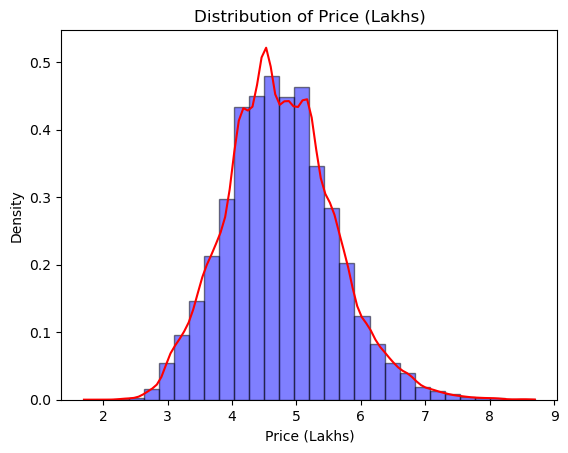

In [12]:
plt.hist(house_price_df['price'], bins=30, alpha=0.5, color='blue', edgecolor='black', density=True)

kde = gaussian_kde(house_price_df['price'])
x_vals = np.linspace(house_price_df['price'].min(), house_price_df['price'].max(), 100)
plt.plot(x_vals, kde(x_vals), color='red')  # KDE curve

plt.xlabel('Price (Lakhs)')
plt.ylabel('Density')
plt.title('Distribution of Price (Lakhs)')
plt.show()

CREATING A NEW FEATURE, PRICE PER SQUARE FEET, WHICH IS USED FOR PROPERTY VALUATION IN PRACTICAL SETTINGS.

In [13]:
house_price_df['price per square feet'] = house_price_df['price']/house_price_df['area']

In [14]:
house_price_df.head()

,bhk,type,area,region,price,price per square feet
0,3,Apartment,685,Andheri West,5.525453,0.008066
1,2,Apartment,640,Naigaon East,3.979869,0.006219
2,2,Apartment,610,Borivali West,5.159055,0.008457
3,2,Apartment,876,Panvel,4.110546,0.004692
4,2,Apartment,659,Mira Road East,4.555034,0.006912


In [15]:
num_feats = house_price_df[['bhk', 'area', 'price', 'price per square feet']]
cat_feats = house_price_df.select_dtypes(include = ['object'])

PLOTTING BOX PLOT TO CHECK FOR OUTLIERS.

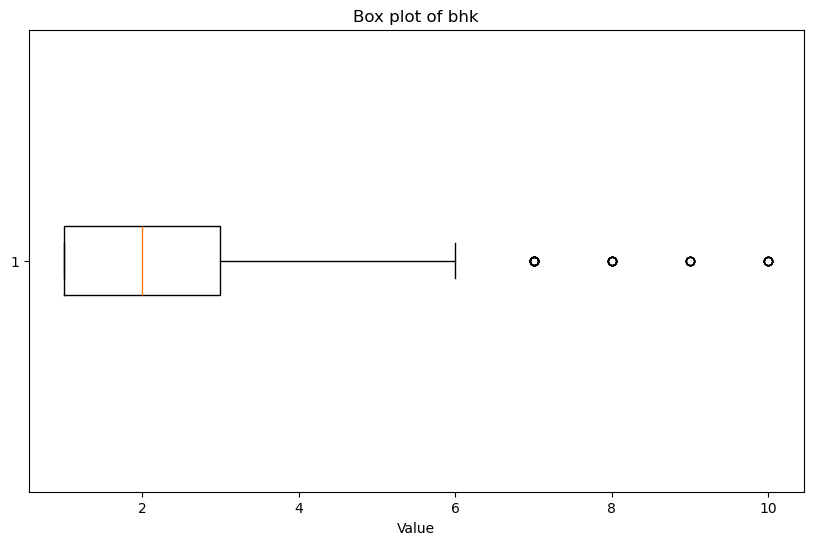

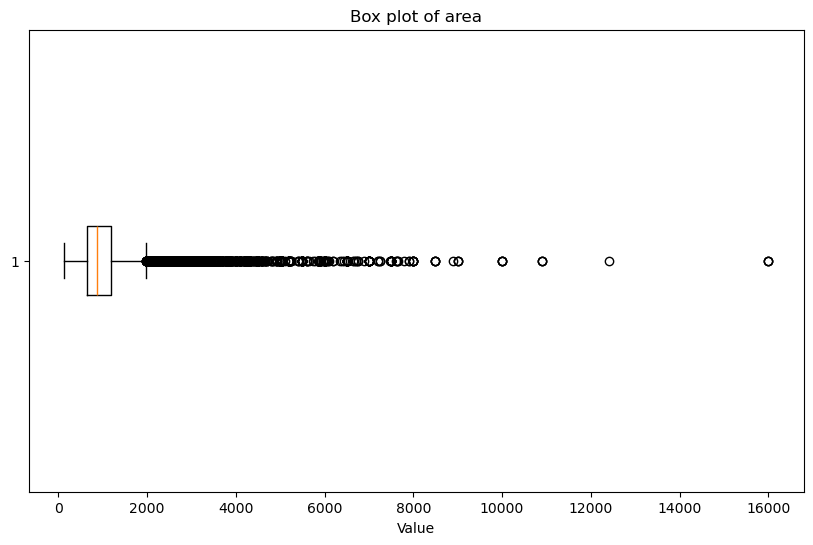

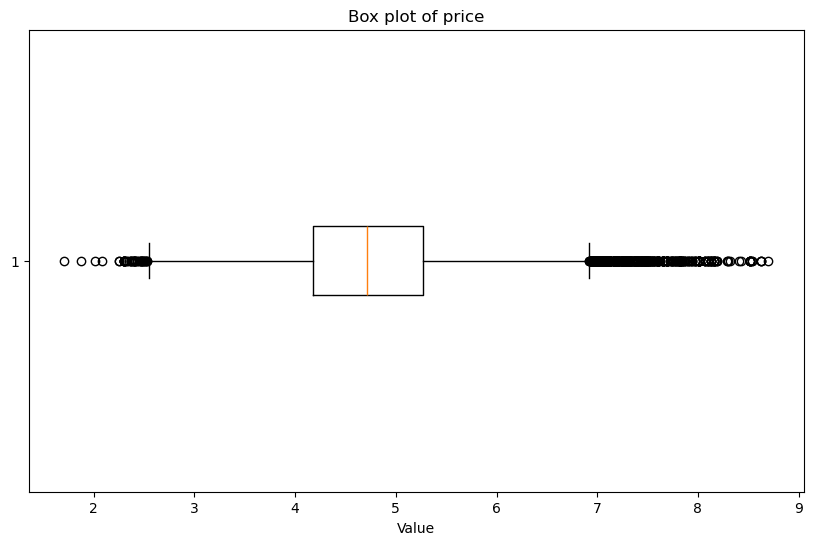

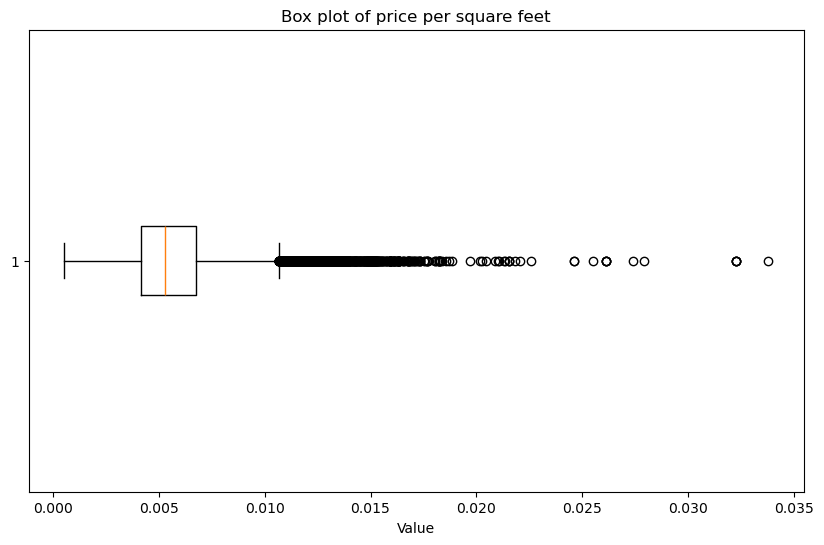

In [16]:
for i, column in enumerate(num_feats.columns):
    plt.figure(figsize = (10,6))
    plt.boxplot(house_price_df[column], vert = False)
    plt.title(f'Box plot of {column}')
    plt.xlabel('Value')
    plt.show()

In [17]:
house_price_df_1 = house_price_df.drop(columns=['type', 'region'])
correlation = house_price_df_1.corr()
correlation

,bhk,area,price,price per square feet
bhk,1.000000,0.787738,0.764761,-0.637812
area,0.787738,1.000000,0.683816,-0.697934
price,0.764761,0.683816,1.000000,-0.401685
price per square feet,-0.637812,-0.697934,-0.401685,1.000000


HEATMAP TO DEMONSTRATE CORRELATION BETWEEN DIFFERENT FEATURES.

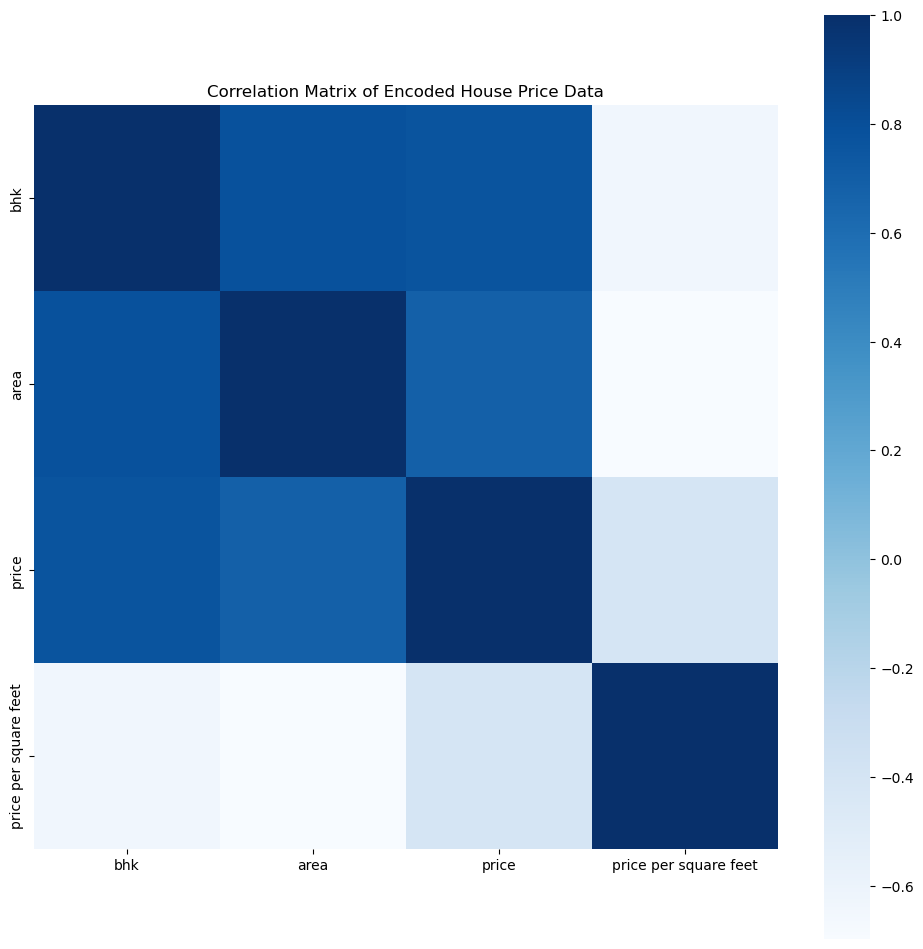

In [18]:
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=False, cmap='Blues')
plt.title("Correlation Matrix of Encoded House Price Data")
plt.show()

In [19]:
house_price_df = pd.concat([house_price_df_1, cat_feats], axis = 1)
house_price_df.head()

,bhk,area,price,price per square feet,type,region
0,3,685,5.525453,0.008066,Apartment,Andheri West
1,2,640,3.979869,0.006219,Apartment,Naigaon East
2,2,610,5.159055,0.008457,Apartment,Borivali West
3,2,876,4.110546,0.004692,Apartment,Panvel
4,2,659,4.555034,0.006912,Apartment,Mira Road East


In [20]:
house_price_df.region = house_price_df.region.apply(lambda x: x.strip())
loc_stats = house_price_df['region'].value_counts(ascending=False)
loc_stats

region
Thane West         14868
Mira Road East      9902
Dombivali           3041
Kandivali East      2568
Kharghar            2362
                   ...  
Police Colony          1
GTB Nagar              1
Bandra                 1
Sector 14 Vashi        1
Goregaon               1
Name: count, Length: 228, dtype: int64

In [21]:
loc_stats.values.sum()

76038

In [22]:
len(loc_stats[loc_stats>10])

114

In [23]:
len(loc_stats[loc_stats<=10])

114

In [24]:
location_stats_less_than_10 = loc_stats[loc_stats<=10]
location_stats_less_than_10

region
Kanjurmarg East      10
Vasind               10
Sector 20 Kamothe    10
Koproli              10
Cuffe Parade          9
                     ..
Police Colony         1
GTB Nagar             1
Bandra                1
Sector 14 Vashi       1
Goregaon              1
Name: count, Length: 114, dtype: int64

In [25]:
len(house_price_df.region.unique())

228

ASSIGNING ALL REGIONS WITH LESS THAN 10 PROPERTIES AS 'other' TO REDUCE THE SIZE OF THE DATAFRAME AND MAKE IT STATISTICALLY REFINED.

In [26]:
house_price_df.region = house_price_df.region.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(house_price_df.region.unique())

115

In [27]:
house_price_df.region.value_counts()

region
Thane West           14868
Mira Road East        9902
Dombivali             3041
Kandivali East        2568
Kharghar              2362
                     ...  
Sector 21 Kamothe       16
Kalwa                   15
Nalasopara East         15
Vangani                 13
Saphale                 12
Name: count, Length: 115, dtype: int64

In [28]:
target_col = 'price'
house_price_df = house_price_df[[col for col in house_price_df.columns if col != target_col] + [target_col]]
house_price_df.head()

,bhk,area,price per square feet,type,region,price
0,3,685,0.008066,Apartment,Andheri West,5.525453
1,2,640,0.006219,Apartment,Naigaon East,3.979869
2,2,610,0.008457,Apartment,Borivali West,5.159055
3,2,876,0.004692,Apartment,Panvel,4.110546
4,2,659,0.006912,Apartment,Mira Road East,4.555034


ONE-HOT ENCODING 'type' AND 'region' TO MAKE IT EASIER TO INCLUDE THOSE FEATURES IN MODEL TRAINING. 

In [30]:
house_price_df_encoded = pd.get_dummies(house_price_df, columns=['type', 'region'], prefix=['type', 'region'])

house_price_df_encoded

,bhk,area,price per square feet,price,type_Apartment,type_Independent House,type_Penthouse,type_Studio Apartment,type_Villa,region_Agripada,...,region_Vasai,region_Vashi,region_Vikhroli,region_Ville Parle East,region_Ville Parle West,region_Virar,region_Virar West,region_Wadala,region_Worli,region_other
0,3,685,0.008066,5.525453,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,640,0.006219,3.979869,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,610,0.008457,5.159055,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2,876,0.004692,4.110546,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,659,0.006912,4.555034,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76033,3,1527,0.004291,6.552508,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76034,5,3049,0.002326,7.090910,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76035,4,3313,0.002085,6.908755,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
76036,2,1305,0.004639,6.054439,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
house_price_df_encoded.shape

(76038, 124)

ASSIGNING INDEPENDENT FEATURES AND TARGET.

In [32]:
X = house_price_df_encoded.drop('price', axis = 1)
Y = house_price_df_encoded['price']

SPLITTING DATA IN TRAINING SET AND TEST SET.

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [36]:
print(X.shape, X_train.shape, X_test.shape)

(76038, 123) (60830, 123) (15208, 123)


DEFINING MODEL TO BE USED IN TRAINING.

In [37]:
model = XGBRegressor()

TRAINING THE MODEL.

In [38]:
model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

COMPARING Y_train WITH training_data_prediction AND Y_test WITH test_data_prediction.

In [39]:
training_data_prediction = model.predict(X_train)

In [40]:
print(training_data_prediction)

[4.060514  6.358305  5.9835453 ... 4.9197855 4.8104444 3.46066  ]


In [41]:
score_1 = metrics.r2_score(Y_train, training_data_prediction)
score_2 = metrics.mean_absolute_error(Y_train, training_data_prediction)
print("R squared error: ", score_1)
print("Mean absolute error: ", score_2)

R squared error:  0.9951559271606959
Mean absolute error:  0.04045270905111622


In [42]:
test_data_prediction = model.predict(X_test)

In [43]:
print(test_data_prediction)

[4.3315244 5.078027  5.420106  ... 3.8182108 4.624255  5.4344263]


In [44]:
score_1_test = metrics.r2_score(Y_test, test_data_prediction)
score_2_test = metrics.mean_absolute_error(Y_test, test_data_prediction)
print("R squared error: ", score_1_test)
print("Mean absolute error: ", score_2_test)

R squared error:  0.9933298006214982
Mean absolute error:  0.044225808517730746


In [45]:
df = pd.DataFrame({'Actual': np.round(Y_test, 2), 
                   'Predicted': np.round(test_data_prediction, 2)})
df.head(10)

,Actual,Predicted
44537,4.33,4.33
54707,5.09,5.08
33616,5.47,5.42
10735,6.69,6.77
75123,4.49,4.43
875,3.04,3.04
13194,4.47,4.48
54679,5.69,5.67
338,3.04,3.04
70184,4.98,4.99


PLOTTING GRAPHS TO SHOW VARIOUS STATISTICAL INFERENCES AFTER TRAINING THE MODEL.

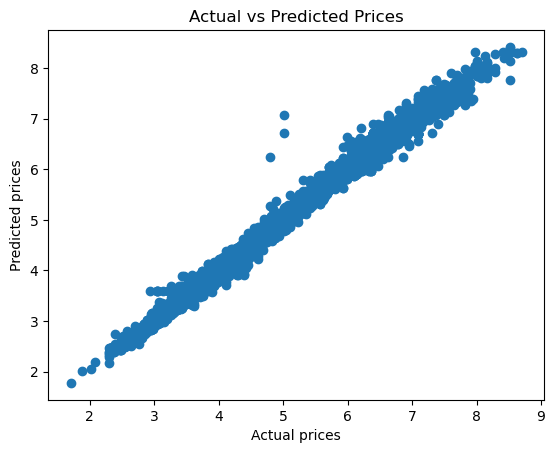

In [46]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices')
plt.title("Actual vs Predicted Prices")
plt.show()

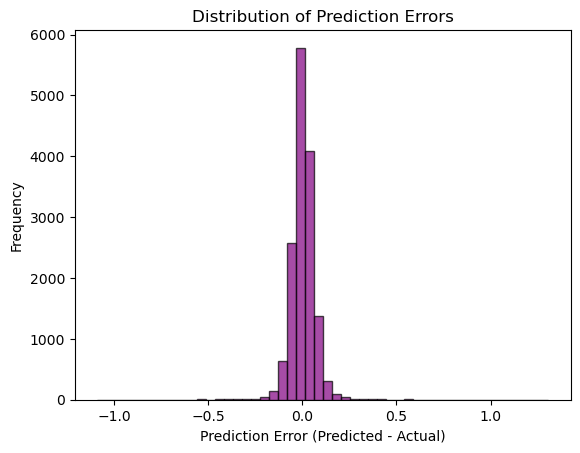

In [47]:
plt.hist((test_data_prediction - Y_test), bins=50, color='purple', edgecolor='black', alpha=0.7)

plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

plt.show()

In [48]:
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved as 'trained_model.pkl'")

Model saved as 'trained_model.pkl'
